In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pygwalker as pyg
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
import numpy as np 

2024-11-25 14:56:55.926648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# importation des différents fichiers dans l'environnement 
X_test = pd.read_csv("X_test_m4HAPAP.csv")
X_train = pd.read_csv("X_train_N1UvY30.csv")
y_train = pd.read_csv("y_train_or6m3Ta.csv")

In [4]:
y_train = pd.read_csv("y_train_or6m3Ta.csv")

In [5]:
# Variables catégorielles à encoder
categorical_columns = ['venue', 'action', 'side']

# Variables numériques
numeric_columns = ['price', 'bid', 'ask', 'bid_size', 'ask_size', 'flux']

# Encoding 
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])


X_train['trade'] = X_train['trade'].astype(int)  
X_test['trade'] = X_test['trade'].astype(int)


def preprocessing(df):
    # 1. Calcul du spread et des variations de prix
    df['spread'] = df['ask'] - df['bid']
    df['spread_change'] = df['spread'].diff()
    df['price_change'] = df['price'].diff()
    df['bid_change'] = df['bid'].diff()
    df['ask_change'] = df['ask'].diff()

    # 2. Volume et dynamique des ordres
    df['bid_ask_ratio'] = df['bid_size'] / df['ask_size']
    df['bid_size_change'] = df['bid_size'].diff()
    df['ask_size_change'] = df['ask_size'].diff()
    df['total_size'] = df['bid_size'] + df['ask_size']

    df['trade_volume'] = df['flux'] * df['trade'].astype(int)

    
    # 4. Dérivées des données temporelles
    df['price_volatility'] = df['price'].rolling(window=5).std()
    df['price_momentum'] = df['price'].diff(periods=5)
    
    # 5. Mesures spécifiques par lieu d’échange
    df['spread_by_venue'] = df.groupby('venue')['spread'].transform('mean')
    df['volume_by_venue'] = df.groupby('venue')['total_size'].transform('mean')

    # 6. Z-Score du prix
    df['price_zscore'] = (df['price'] - df['price'].mean()) / df['price'].std()


    # 8. Application des transformations demandées
    df['log_bid_size'] = np.log(np.abs(df['bid_size'] + 1))
    df['log_ask_size'] = np.log(np.abs(df['ask_size'] + 1))
    df['log_flux'] = np.log(np.abs(df['flux']) + 1) * np.sign(df['flux'])
    
    # Remplacement du spread calculé (corrigé pour les tailles et les prix)
    df['spread_size'] = df['ask_size'] - df['bid_size']
    df['spread_price'] = df['ask'] - df['bid']

    return df

# Exemple d'utilisation :
# X_train = preprocessing(X_train)

X_train = preprocessing(X_train)
X_test = preprocessing(X_test)
# Sélection des colonnes nécessaires pour le modèle
selected_columns = ['venue', 'action', 'trade',  'bid', 'ask','price', 'log_bid_size', 'log_ask_size', 'log_flux']


In [6]:
def summarize_by_obs(df):
    # Statistiques sur les variables numériques
    summary = df.groupby('obs_id').agg({
        'spread': ['mean', 'std', 'min', 'max'],
        'spread_change': ['mean', 'std'],
        'price_change': ['mean', 'std'],
        'bid_change': ['mean', 'std'],
        'ask_change': ['mean', 'std'],
        'bid_ask_ratio': ['mean', 'std'],
        'bid_size_change': ['mean', 'std'],
        'ask_size_change': ['mean', 'std'],
        'total_size': ['mean', 'std'],
        'trade_volume': ['mean', 'std'],
        'price_volatility': ['mean'],
        'price_momentum': ['mean'],
        'spread_by_venue': ['mean'],
        'volume_by_venue': ['mean'],
        'price_zscore': ['mean', 'std'],
        'log_bid_size': ['mean', 'std'],
        'log_ask_size': ['mean', 'std'],
        'log_flux': ['mean', 'std'],
        'spread_size': ['mean', 'std'],
        'spread_price': ['mean', 'std'],
    })

    # Aplatir l'index multi-niveaux des statistiques numériques
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    
    # Calcul des fréquences pour 'venue', 'action', et 'side'
    for col in ['venue', 'action', 'side']:
        # Calcul des fréquences pour chaque obs_id
        freq = df.groupby('obs_id')[col].value_counts(normalize=True).unstack(fill_value=0)
        
        # Joindre les fréquences avec le résumé principal
        # Ajout d'un suffixe pour éviter le conflit de noms de colonnes
        freq.columns = [f"{col}_{int(i)}" for i in freq.columns]  # ajout du suffixe
        summary = summary.join(freq, how='left')

    return summary


In [7]:
X_train_summarize = summarize_by_obs(X_train)
X_test_summarize = summarize_by_obs(X_test)

/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_52410/1396377731.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'spread': ['mean', 'std', 'min', 'max', lambda x: skew(x), lambda x: kurtosis(x)],
/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_52410/1396377731.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'bid_ask_ratio': ['mean', 'std', lambda x: skew(x), lambda x: kurtosis(x)],
/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_52410/1396377731.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'total_size': ['mean', 'std', lambda x: skew(x), lambda x: kurtosis(x)],
/

KeyboardInterrupt: 

In [ ]:
X_train_summarize

,spread_mean,spread_std,spread_min,spread_max,spread_change_mean,spread_change_std,price_change_mean,price_change_std,bid_change_mean,bid_change_std,...,venue_1,venue_2,venue_3,venue_4,venue_5,action_0,action_1,action_2,side_0,side_1
obs_id,,,,,,,,,,,,,,,,,,,,,
0,0.0152,0.005021,0.01,0.02,1.010101e-04,0.001005,0.001414,0.221240,0.0000,0.000000,...,0.14,0.13,0.02,0.59,0.07,0.51,0.49,0.00,0.48,0.52
1,0.0392,0.006917,0.02,0.06,1.419698e-16,0.004495,-0.004200,0.223648,0.0004,0.002814,...,0.07,0.10,0.05,0.51,0.21,0.49,0.43,0.08,0.32,0.68
2,0.0107,0.002564,0.01,0.02,-1.000000e-04,0.001738,-0.000200,0.064589,-0.0004,0.004000,...,0.02,0.01,0.23,0.44,0.19,0.54,0.46,0.00,0.56,0.44
3,0.1310,0.046482,0.10,0.20,9.000000e-04,0.021560,-0.005000,0.278758,0.0010,0.010000,...,0.18,0.11,0.01,0.43,0.09,0.50,0.49,0.01,0.84,0.16
4,0.0174,0.004408,0.01,0.02,-8.000000e-04,0.009065,0.005100,0.091469,-0.0009,0.010060,...,0.09,0.02,0.10,0.42,0.18,0.48,0.52,0.00,0.53,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160795,0.1044,0.021757,0.05,0.13,-1.000000e-04,0.013446,0.092600,1.026390,0.0001,0.004819,...,0.13,0.04,0.04,0.58,0.09,0.49,0.50,0.01,0.52,0.48
160796,0.0954,0.016232,0.06,0.12,-1.000000e-04,0.005945,-0.001100,0.676790,-0.0002,0.006027,...,0.21,0.00,0.03,0.39,0.27,0.52,0.47,0.01,0.42,0.58
160797,0.0505,0.024011,0.01,0.08,-2.000000e-04,0.008759,-0.000200,0.252539,0.0000,0.002010,...,0.11,0.10,0.06,0.35,0.27,0.49,0.51,0.00,0.47,0.53


In [ ]:
from sklearn.preprocessing import StandardScaler
X_train_summarize = X_train_summarize.reset_index(drop=True)
X_test_summarize = X_test_summarize.reset_index(drop=True)
# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_summarize)
X_test_scaled = scaler.transform(X_test_summarize)

# Reconversion en DataFrame avec les noms de colonnes d'origine
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_summarize.columns, index=X_train_summarize.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_summarize.columns, index=X_test_summarize.index)

In [ ]:
from sklearn.decomposition import PCA

# Appliquer l'ACP en conservant 95% de la variance
pca = PCA(n_components=0.97, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Vérifier le nombre de composantes
print("Nombre de composantes principales conservées:", X_train_pca.shape[1])


Nombre de composantes principales conservées: 27


In [ ]:
X_train_pca

array([[ 3.70307369e-01, -2.05815098e+00,  9.28565473e-02, ...,
         6.87860511e-01,  3.26362393e-02,  9.42511259e-03],
       [ 8.57662829e-04, -5.18578435e-01,  3.83102630e-02, ...,
        -4.31087082e-02, -5.56831367e-03,  5.17247344e-01],
       [-1.29123258e+00,  5.46870727e+00,  1.85630906e-01, ...,
        -6.52650965e-01,  2.52846185e-02,  5.51778781e-02],
       ...,
       [-1.56980895e-02, -5.39171776e-01, -8.47576415e-02, ...,
         4.02842628e-01,  3.92962237e-03,  1.38275209e-02],
       [-6.62095447e-02, -4.54045501e-01, -3.96590558e-01, ...,
        -8.57214490e-02,  1.69479228e-03, -3.89759384e-02],
       [ 2.96207635e-02, -6.24505852e-01,  4.25590579e-02, ...,
         2.99829942e-01,  7.91497155e-03, -4.03188201e-02]])

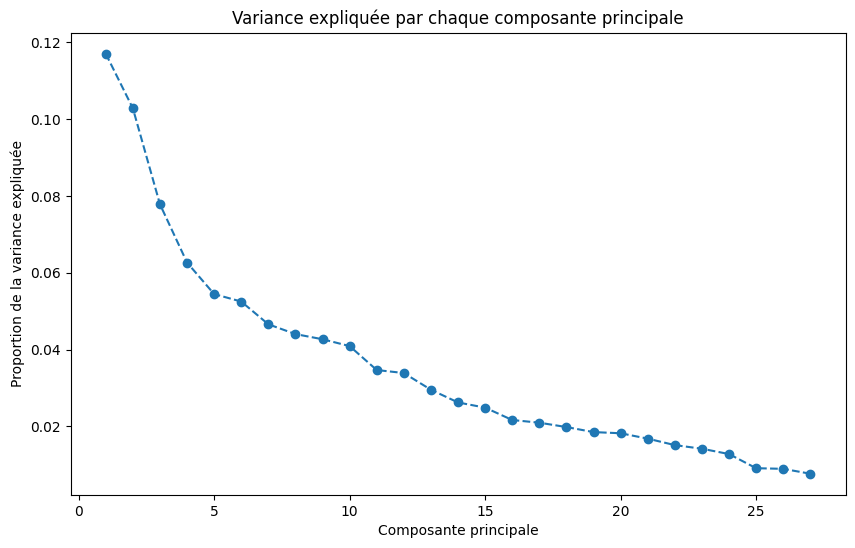

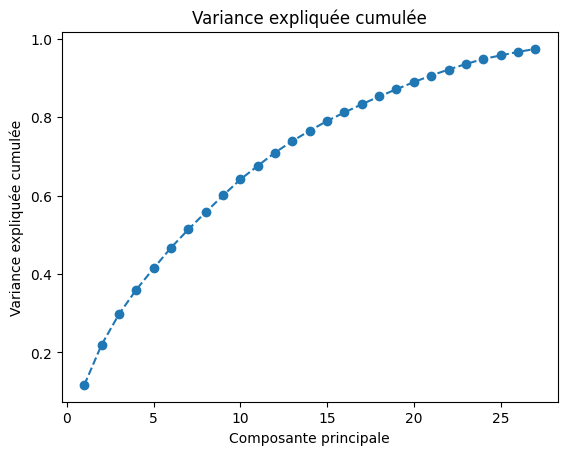

In [ ]:
import matplotlib.pyplot as plt

# Afficher la proportion de variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

# Visualisation de la variance expliquée par chaque composante
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Composante principale')
plt.ylabel('Proportion de la variance expliquée')
plt.title('Variance expliquée par chaque composante principale')
plt.show()

# Afficher la proportion cumulée de variance expliquée
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée')
plt.show()


In [ ]:
from tensorflow.keras.utils import to_categorical
# Exemple de labels générés aléatoirement (à remplacer par tes vraies catégories cibles)
num_observations = X_train_pca.shape[0]
Y= to_categorical(y_train['eqt_code_cat'], num_classes=24)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Définir le modèle XGBoost
xgb = XGBClassifier(use_label_encoder=False, random_state=42)

# Nouvelle grille de paramètres
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1],
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,                 # Testez 20 combinaisons pour un bon équilibre
    scoring='accuracy',
    cv=3,                      # Validation croisée à 3 plis
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entraînement
random_search.fit(X_train_pca, y_train['eqt_code_cat'])

# Meilleurs paramètres
print("Best parameters:", random_search.best_params_)
print("Best accuracy:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.8min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.8min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.8min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:13:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:13:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:13:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time= 6.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:16:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.8min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:16:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:18:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time= 5.4min
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time= 5.4min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:19:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:19:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:19:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.8; total time= 3.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.8min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.8min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:22:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time= 6.6min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:28:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.8; total time=11.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.8; total time=10.9min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.8; total time=10.8min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:32:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time= 6.1min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:34:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time= 5.9min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time= 6.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.8; total time=11.4min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:44:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.8; total time=11.4min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.8; total time=11.3min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:46:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time= 2.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time= 6.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.8; total time= 6.1min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time= 3.9min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time= 6.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time= 6.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.8; total time= 6.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:55:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time= 3.9min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time= 3.8min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=14.9min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:09:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=15.3min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=13.8min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.8; total time=15.4min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time= 4.8min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:16:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time= 5.1min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:18:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time= 5.5min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:22:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=13.2min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=0.8; total time=13.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:23:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 4.5min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:27:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time= 9.4min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:27:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time= 9.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.8; total time= 9.0min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 4.5min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:32:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.8; total time= 4.5min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:32:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time= 2.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time= 2.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time= 2.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.4min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:36:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time= 4.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.3min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.3min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:38:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time= 4.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:38:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time= 4.6min
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time= 4.1min
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time= 3.7min
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time= 3.7min


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}
Best accuracy: 0.2796641791044776


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialisation et entraînement du modèle XGBClassifier
xgb_model = XGBClassifier(
    subsample = 0.8,
    n_estimators=300,  
    learning_rate=0.05,  
    gamma = 1,
    colsample_bytree =  0.8,
    max_depth=9,       
    random_state=42,   
    use_label_encoder=False  
)

# Entraînement du modèle
xgb_model.fit(X_train_scaled, y_train['eqt_code_cat'])

# Prédiction sur les données d'entraînement
predictions = xgb_model.predict(X_train_scaled)

# Évaluation des performances
print("XGBoost Accuracy:", accuracy_score(y_train['eqt_code_cat'], predictions))


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8621517412935323


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Entraînement d'un modèle RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train['eqt_code_cat'])  # Assurez-vous que y_train est dans un format compatible (catégories entières)

# Prédiction et évaluation
predictions = rf_model.predict(X_train_scaled)
print("Random Forest Accuracy:", accuracy_score(y_train['eqt_code_cat'], predictions))



KeyboardInterrupt: 

In [ ]:
predictions_bis = xgb_model.predict(X_test_scaled)

In [ ]:
df_prediction = pd.DataFrame(data = {'eqt_code_cat':predictions_bis})
df_prediction.to_csv('y_prediction_xgb_opti.csv')

In [ ]:
df_prediction

,eqt_code_cat
0,10
1,11
2,0
3,13
4,0
...,...
160795,13
160796,1
160797,15
160798,11


In [ ]:

Y

,obs_id,eqt_code_cat
0,0,10
1,1,15
2,2,0
3,3,13
4,4,0
...,...,...
160795,160795,13
160796,160796,1
160797,160797,3
160798,160798,11


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_train_pca, Y['eqt_code_cat'], test_size=0.2, random_state=42)

# Initialiser le modèle RandomForest
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000]  # Les valeurs à tester pour n_estimators
}


# Utiliser GridSearchCV pour effectuer la validation croisée et trouver le meilleur n_estimators
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ....................................n_estimators=10; total time=  57.7s
[CV] END ....................................n_estimators=10; total time=  57.7s
[CV] END ....................................n_estimators=10; total time=  57.9s
[CV] END ....................................n_estimators=10; total time=  58.9s
[CV] END ....................................n_estimators=10; total time=  56.3s
[CV] END ....................................n_estimators=50; total time= 5.8min
[CV] END ....................................n_estimators=50; total time= 5.8min
[CV] END ....................................n_estimators=50; total time= 5.8min
[CV] END ....................................n_estimators=50; total time= 5.9min
[CV] END ....................................n_estimators=50; total time= 4.9min
[CV] END ...................................n_estimators=100; total time=10.5min
[CV] END ...................................n_est

KeyboardInterrupt: 

In [ ]:
# Résultats de la recherche de grille
print("Meilleur nombre d'estimateurs:", grid_search.best_params_['n_estimators'])

# Utiliser le meilleur modèle trouvé pour faire des prédictions
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_scaled)

# Évaluer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Précision du modèle avec {grid_search.best_params_["n_estimators"]} estimateurs : {accuracy:.4f}')

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train['eqt_code_cat'])

predictions = xgb_model.predict(X_train_scaled)
print("XGBoost Accuracy:", accuracy_score(y_train['eqt_code_cat'], predictions))


ModuleNotFoundError: No module named 'xgboost'